
The U2OS dataset is composed of pairs of noisy and high SNR nuclei images acquired in 
fluorescence microscopy. They were originally used in Weigert et al (2018) to showcase
CARE denoising.

In [10]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics import CAREamist
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

The CARE U2OS dataset is composed of thousands of examples organized in train and test:

- train
    - low: low SNR data
    - GT: high SNR data
- test
    - low: low SNR data
    - GT: high SNR data
 


In [24]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
download = portfolio.denoising.CARE_U2OS.download(root_path)

# path to the training data
root_path = root_path / "denoising-CARE_U2OS.unzip" / "data" / "U2OS"
train_path = root_path / "train" / "low"
target_path = root_path / "train" / "GT"

## Visualize data

Text(0.5, 1.0, 'Target image')

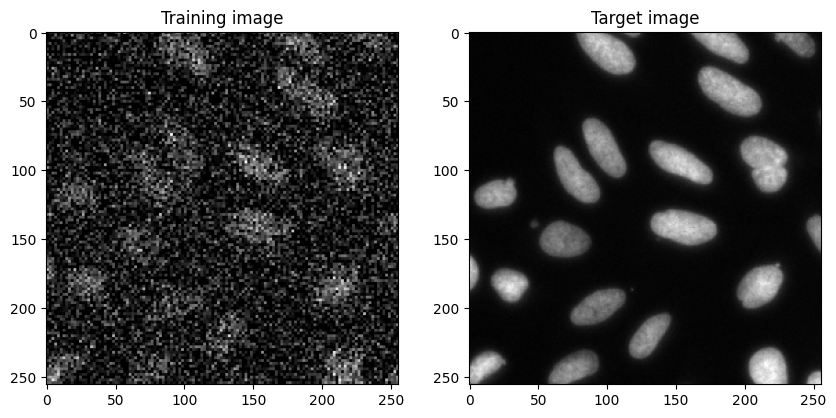

In [25]:
# load training image and target, and show them side by side
train_files = list(train_path.rglob("*.tif"))
train_files.sort()

target_files = list(target_path.rglob("*.tif"))
target_files.sort()

# select random example
ind = np.random.randint(len(train_files))
train_image = tifffile.imread(train_files[ind])
train_target = tifffile.imread(target_files[ind])

# plot the two images and a crop
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[00].set_title("Training image")

ax[1].imshow(train_target, cmap="gray")
ax[1].set_title("Target image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [26]:
config = create_care_configuration(
    experiment_name="care_n2n",
    data_type="tiff",
    axes="YX",
    patch_size=(128, 128),
    batch_size=32,
    num_epochs=20,
)

print(config)

{'algorithm_config': {'algorithm': 'care',
                      'loss': 'mae',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': False,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 32,
                 'data_type': 'tiff',
                 'patch_size': [128, 128],
                 'transforms': [{'mean': 0.485,
   

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [5]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_path,
    train_target=target_path,
    val_percentage=0.01,
    val_minimum_split=20,
)

No working directory provided. Using current working directory: /localscratch/careamics-examples/applications/n2n/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localscratch/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-8Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will 

Sanity Checking: |                                                                                            …

/localscratch/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/localscratch/miniconda3/envs/careamics/

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 20.61it/s, train_loss_step=0.661]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████████████████████████| 18/18 [00:00<00:00, 26.72it/s, train_loss_step=0.635, val_loss=0.742, train_loss_epoch=0.712]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████| 18/18 [00:00<00:00, 27.00it/s, train_loss_step=0.62, val_loss=0.639, train_loss_epoch=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████| 18/18 [00:00<00:00, 27.27it/s, train_loss_step=0.61, val_loss=0.626, train_loss_epoch=0.623]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████████████████████████| 18/18 [00:00<00:00, 26.92it/s, train_loss_step=0.603, val_loss=0.615, train_loss_epoch=0.613]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████████████████████████████| 18/18 [00:00<00:00, 26.84it/s, train_loss_step=0.599, val_loss=0.609, train

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|███████████████████████████████████| 18/18 [00:00<00:00, 24.59it/s, train_loss_step=0.588, val_loss=0.6, train_loss_epoch=0.592]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training, and we can use the test
set.

In [6]:
test_path = root_path / "test" / "low"

prediction = careamist.predict(source=test_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

### Visualize the prediction

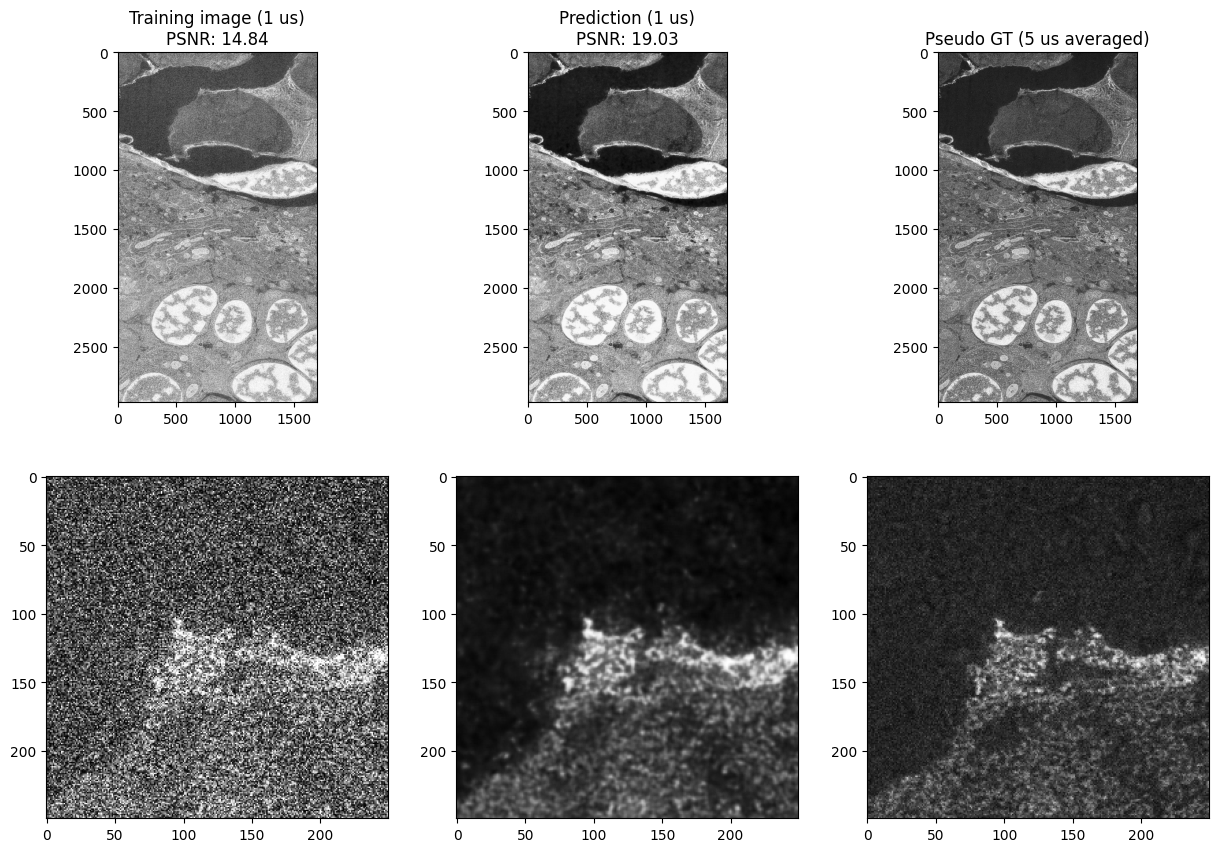

In [9]:
# Show two images
test_GT_path = root_path / "test" / "GT"
test_GT_files = list(test_GT_path.rglob("*.tif"))
test_GT_files.sort()

test_low_path = root_path / "test" / "low"
test_low_files = list(test_low_path.rglob("*.tif"))
test_low_files.sort()

test_GT = [tifffile.imread(f) for f in test_GT_files]
test_low = [tifffile.imread(f) for f in test_low_files]

# images to show
images = np.random.choice(range(len(test_GT)), 3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    pred_image = prediction[images[i]]
    psnr_noisy = scale_invariant_psnr(test_GT[images[i]], test_low[images[i]])
    psnr_result = scale_invariant_psnr(test_GT[images[i]], pred_image)

    ax[i, 0].imshow(test_low[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}")

    ax[i, 2].imshow(test_GT[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")

### Compute metrics

In [ ]:
psnrs = np.zeros((len(prediction), 1))

for i, (pred, gt) in enumerate(zip(prediction, test_GT)):
    psnrs[i] = scale_invariant_psnr(gt, pred)

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")

PSNR: 27.09 +/- 2.90
Reported PSNR: 27.71
